In [1]:
#Importing modules
import os
import datetime
import torch
import torch.nn as nn
import numpy as np

#Importing custom modules
from flow_expansion import data_gen as dg
from flow_expansion import series_expansion_laplace as sel #replace mfl by sel
from flow_expansion import inn #replace i by inn
from flow_expansion import plotting
from flow_expansion import entropy_calc as ec
from flow_expansion import geometry as geo

### Example Code using the Normalising Flow Approximation for a Gaussian Toy Model

This notebook shows how the on a Gaussian toy model trained normalising flow is used to calculate the information entropy and foremost the moments via the flow expansion.


#### 1 Generate Toy Data

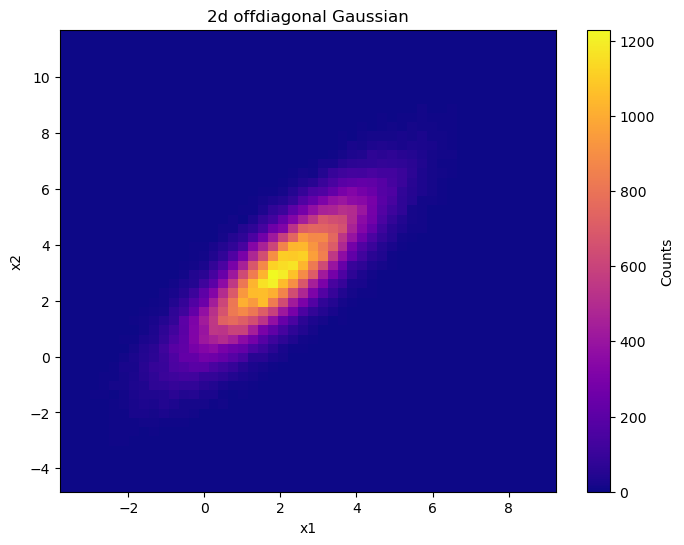

In [2]:
#Dimensionality of the example (only implemented for 2D)
N_DIM = 2

#Choose 2D-Gaussian with off-diagonal covariance matrix
EXAMPLE = 'offdiag_gaussian'
PARAMS = [np.array([2, 3]), np.array([[2, 2],[2, 3]])]

#Number of samples
NSAMPLES = 125000

#Plotting and saving
PLOT = True
SAVE = True
path_to_save = os.getcwd()+'/samples/'+EXAMPLE+'/'+str(datetime.date.today())+'/'

#Generate toy data
samples = dg.generate_data(EXAMPLE, PARAMS, N_DIM, NSAMPLES, PLOT, SAVE, path_to_save)

#### 2 Train Normalising Flow

100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


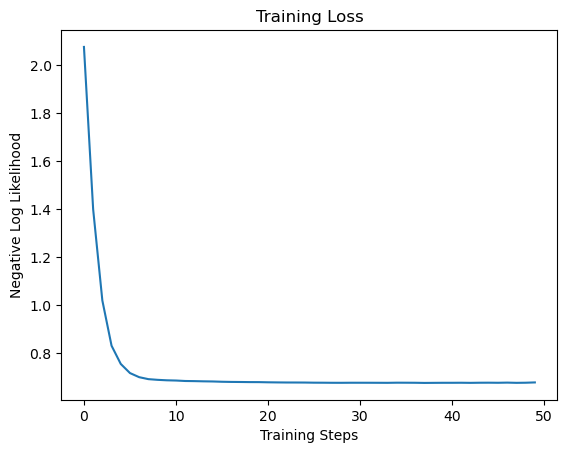

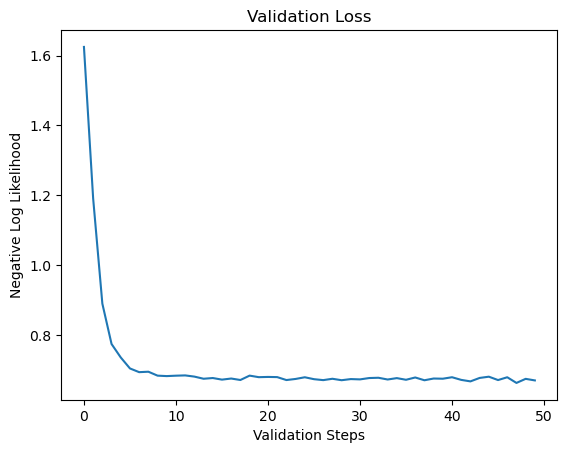

In [3]:
#Network Settings
NETWORK = 'vanilla_inn'
BATCHSIZE = 3000
N_LAYERS = 1
WIDTH_SUBNET = 64
PERMUTE_SOFT = True

#Training Settings
LEARNING_RATE = 1e-2
NUM_EPOCS = 50
DEVICE = torch.device('cpu')

#Plotting and saving
PLOT = True
SAVE = True

#Perform training
n_flow = inn.train_inn(samples, NETWORK, BATCHSIZE, N_DIM, N_LAYERS, WIDTH_SUBNET, LEARNING_RATE, NUM_EPOCS, DEVICE, PERMUTE_SOFT, PLOT, SAVE, path_to_save)

In [4]:
import importlib
importlib.reload(plotting)

<module 'flow_expansion.plotting' from '/Users/tobiasrospel/Desktop/Universität/Master/MasterThesis/Github/partition-nf-expansion/flow_expansion/plotting.py'>

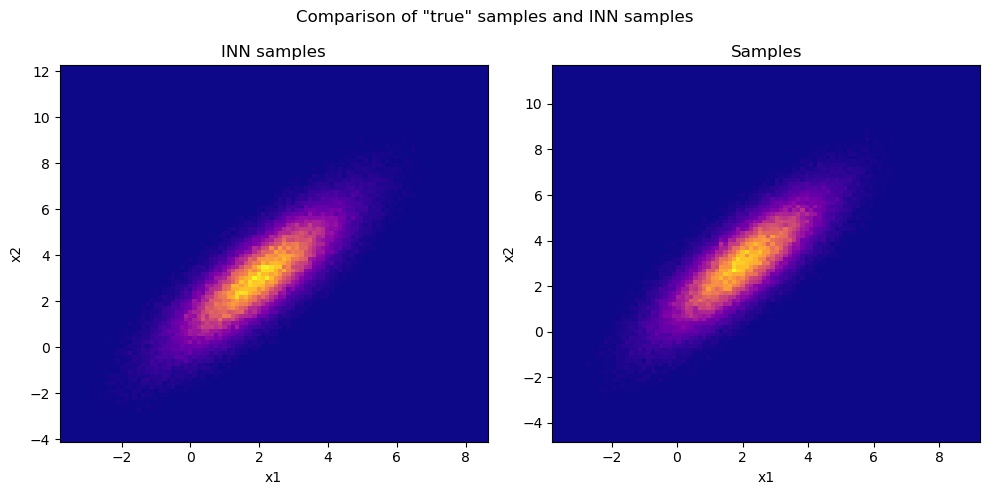

/Users/tobiasrospel/opt/anaconda3/envs/mthesis/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tobiasrospel/opt/anaconda3/envs/mthesis/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tobiasrospel/opt/anaconda3/envs/mthesis/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tobiasrospel/opt/anaconda3/envs/mthesis/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

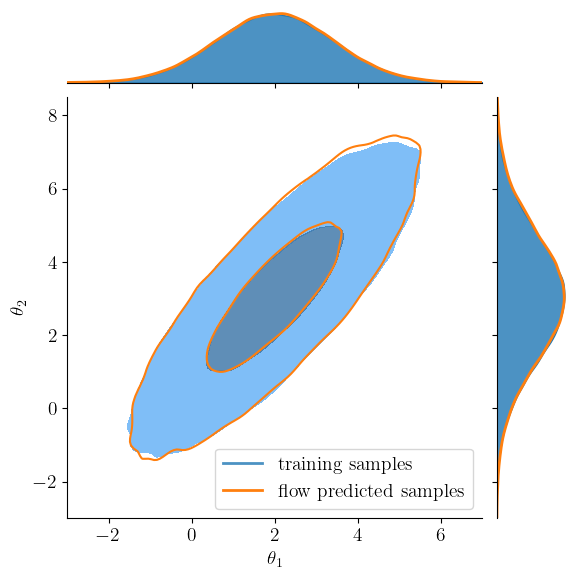

In [5]:
#Compare ground truth and learned distribution
samples_pred = inn.plot_results(n_flow, NSAMPLES, N_DIM , samples, save = False, path_to_files = "", direction = 0, NETWORK = NETWORK, visualize2d = True)

#Prettier plot with seaborn (takes about 3 min)
plotting.toy_model_plot_comparison_samples_and_prediction(samples, samples_pred, save = False, save_path = None)

#### 3 Entropy Calculation

In [6]:
#Entropy via normalising flow
entropy_flow = ec.entropy_flow(n_flow, DEVICE, N_DIM, NSAMPLES)
print('Entropy via normalising flow: ', np.round(entropy_flow,2))

#Entropy via KDE estimate
entropy_kde = ec.entropy_kde_estimate(samples, grid_size = 100, plot = False)
print('Entropy via KDE estimate: ', np.round(entropy_kde,2))

#Entropy via histogram
entropy_hist = ec.entropy_hist_estimate(samples, bins = 20)
print('Entropy via histogram estimate: ', np.round(entropy_hist,2))

#Entropy analytical (only for 2D Gaussian)
if EXAMPLE == 'offdiag_gaussian':
    cov = PARAMS[1]
    entropy_analytical = ec.entropy_ana_gaussian(cov, N_DIM)
    print('Entropy analytical: ', np.round(entropy_analytical,2))
else:
    raise ValueError('Analytical entropy only implemented for off-diagonal Gaussian')

Entropy via normalising flow:  3.2
Entropy via KDE estimate:  3.21
Entropy via histogram estimate:  3.24
Entropy analytical:  3.18


#### 4 Moment Calculation

In [7]:
import importlib
importlib.reload(sel)

<module 'flow_expansion.series_expansion_laplace' from '/Users/tobiasrospel/Desktop/Universität/Master/MasterThesis/Github/partition-nf-expansion/flow_expansion/series_expansion_laplace.py'>

In [8]:
#Perform series expansion
ORDER_SERIES = 3
ORDER_MOMENT = 5

mean_var_skew_kurt_sel = sel.mean_var_skew_kurt_2d(n_flow, ORDER_SERIES, ORDER_MOMENT, N_DIM, NETWORK)

Via flow series:
Mean:       [  2.00   3.06]
Covariance:
           [  2.00   1.98]
           [  1.98   3.01]
Skewness:   [ -0.00   0.19]
Kurtosis:   [  3.00   2.97]


#### 5 Geometry of the flow

In [9]:
importlib.reload(geo)

<module 'flow_expansion.geometry' from '/Users/tobiasrospel/Desktop/Universität/Master/MasterThesis/Github/partition-nf-expansion/flow_expansion/geometry.py'>

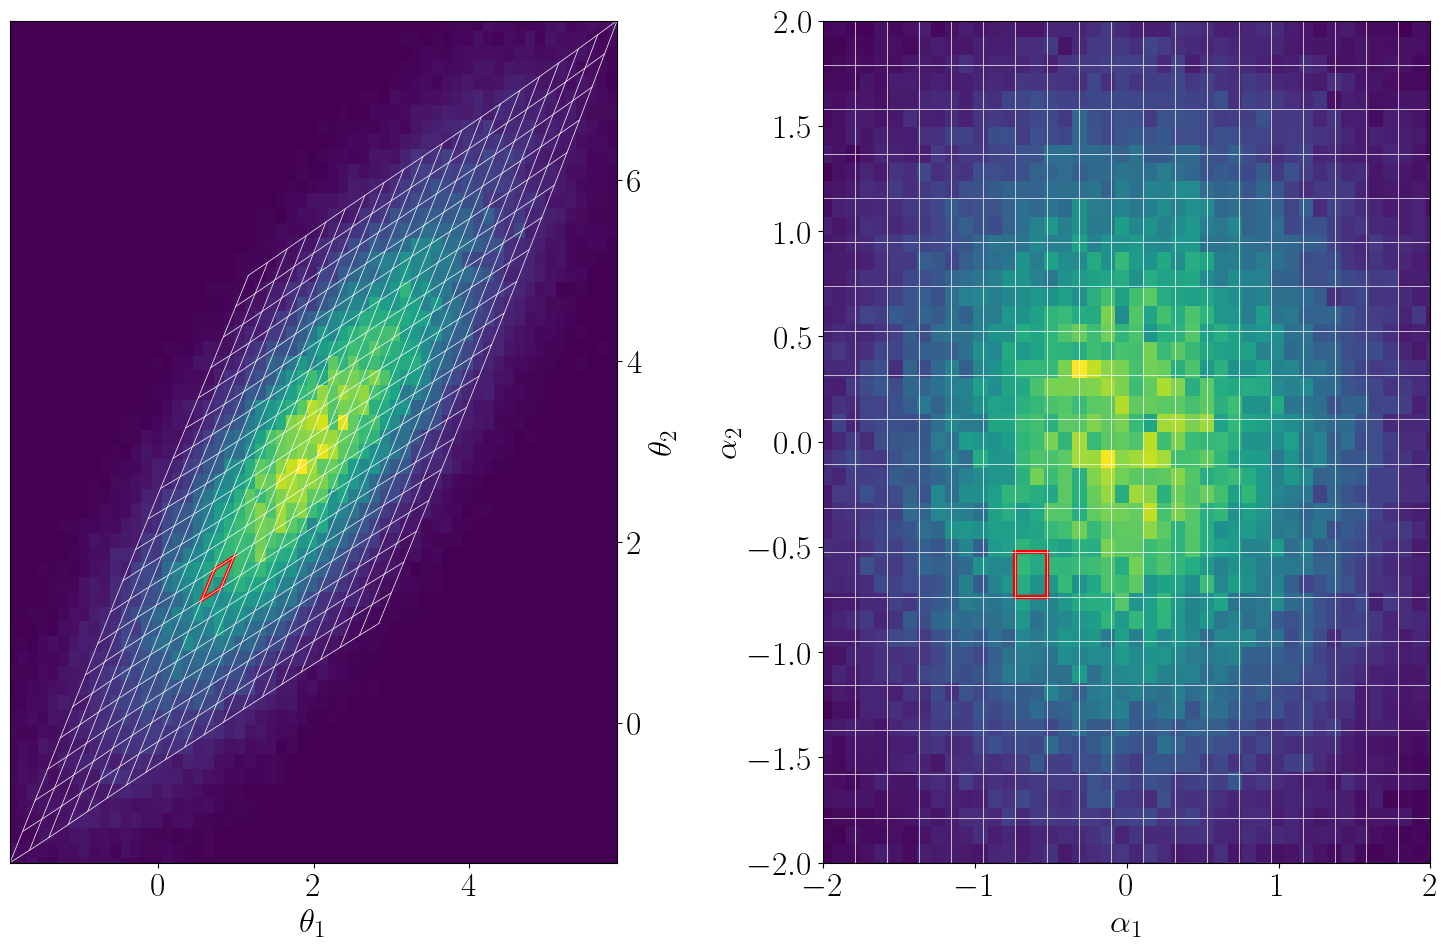

Logdet at specific box: 0.3552954805104771
Area of specific box in theta space: 0.06264589793844866
Area of specific box in alpha space: 0.04432132963988919
Jacobian at specific box: [[1.83852977 2.79841069]
 [1.41837406 2.37825498]]
Kappa: 2.1083923725917177, Gamma_1: -0.269862605000918, Gamma_2: 2.243323675092178, Omega: 0.8249496160049383


In [10]:
geo.geometrical_volume_change(n_flow, path_to_save, NSAMPLES, gridsize=20, N_DIM = N_DIM)

#### Appendix: Network Settings for Union2.1 dataset (supernova)

If replacing the samples through posterior samples of the Supernova Union2.1 dataset, we used the following network settings during the computations:

In [11]:
# #Entropy calculation network settings for supernova
# BATCHSIZE = 3000
# N_LAYERS = 2
# LEARNING_RATE = 1e-2 
# WIDTH_SUBNET = 128
# NUM_EPOCS = 100
# NETWORK = 'vanilla_inn'
# PERMUTE_SOFT = True

# #Flow expansion network settings for supernova (only different params new defined)
# N_LAYERS_mf = 1 
# LEARNING_RATE_mf = 1e-1
# WIDTH_SUBNET_mf = 32